In [1]:
from IPython.display import clear_output
from google.colab import drive
drive.mount('/content/drive')
!wget http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/horse2zebra.zip
!unzip horse2zebra.zip
!rm horse2zebra.zip
clear_output()

In [2]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from glob import glob
from tqdm.notebook import tqdm
from itertools import chain

torch.random.manual_seed(123)
np.random.seed(123)

In [3]:
horses_train = glob('horse2zebra/trainA/'+'/*')
zebras_train = glob('horse2zebra/trainB/'+'/*')

horses_test = glob('horse2zebra/testA/'+'/*')
zebras_test = glob('horse2zebra/testB/'+'/*')

horses_train, zebras_train, horses_test, zebras_test = [np.array([str(i) for i in j]) for j in [horses_train, zebras_train, horses_test, zebras_test]]
len(horses_train), len(zebras_train), len(horses_test), len(zebras_test)

(1067, 1334, 120, 140)

In [73]:
""" # if validation is needed
from sklearn.model_selection import train_test_split

horses_train, horses_valid = train_test_split(horses_train, test_size=0.1, shuffle=True, random_state=123)
zebras_train, zebras_valid = train_test_split(zebras_train, test_size=0.15, shuffle=True, random_state=123)
len(horses_train), len(horses_valid), len(zebras_train), len(zebras_valid), len(horses_test), len(zebras_test)
"""

(960, 107, 1133, 201, 120, 140)

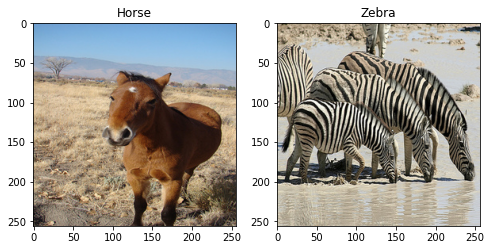

In [74]:
plt.figure(figsize=(8,6))
plt.subplot(121)
plt.title('Horse')
horse = cv2.imread(horses_train[np.random.randint(len(horses_train))])
horse = cv2.cvtColor(horse, cv2.COLOR_BGR2RGB)
plt.imshow(horse)
plt.subplot(122)
plt.title('Zebra')
zebra = cv2.imread(zebras_train[np.random.randint(len(zebras_train))])
zebra = cv2.cvtColor(zebra, cv2.COLOR_BGR2RGB)
plt.imshow(zebra)
plt.show()

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 2
epochs = 40
PATH = r'/content/drive/My Drive/data/cycle_GAN.pth'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
transforms = T.Compose([
                        T.ToPILImage(),
                        T.Resize(int(IMAGE_SIZE*1.33)),
                        T.RandomCrop((IMAGE_SIZE, IMAGE_SIZE)),
                        T.RandomHorizontalFlip(),
                        T.ToTensor(),
                        T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [6]:
class HorseToZebra(Dataset):
    def __init__(self, horses, zebras, transforms):
        self.horses = horses
        self.zebras = zebras
        self.transforms = transforms

    def __len__(self):
        return max(len(self.horses), len(self.zebras))

    def __getitem__(self, ix):
        horse = self.horses[ix % len(self.horses)]
        zebra = self.zebras[np.random.randint(len(self.zebras))]
        horse = cv2.imread(horse)
        horse = cv2.cvtColor(horse, cv2.COLOR_BGR2RGB)
        zebra = cv2.imread(zebra)
        zebra = cv2.cvtColor(zebra, cv2.COLOR_BGR2RGB)
        return horse, zebra

    def collate_fn(self, batch):
        horses, zebras = list(zip(*batch))
        horses = torch.cat([self.transforms(img)[None].float().to(device) for img in horses], 0)
        zebras = torch.cat([self.transforms(img)[None].float().to(device) for img in zebras], 0)
        return horses, zebras

In [7]:
def weights_init(obj):
    classname = obj.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(obj.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(obj.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(obj.bias.data, 0.0)

def load_test_tensor(test_array: np.array = horses_test):
    image_idx = np.random.randint(len(test_array))
    image = cv2.imread(test_array[image_idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = transforms(image)[None].float().to(device)
    return image, image_tensor

invTrans = T.Compose([T.Normalize(mean = [ 0., 0., 0. ],
                                      std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                          T.Normalize(mean = [ -0.5, -0.5, -0.5 ],
                                      std = [ 1., 1., 1. ]),
                          T.ToPILImage(),
                         ])

In [8]:
train_dataset = HorseToZebra(horses_train, zebras_train, transforms)
# valid_dataset = HorseToZebra(horses_valid, zebras_valid, transforms)  # uncomment if validation needed

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_dataset.collate_fn)

# valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=valid_dataset.collate_fn)

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(in_features),
        )
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, num_residual_blocks=9):
        super(Generator, self).__init__()
        out_features = 64
        channels = 3
        model = [
                 nn.ReflectionPad2d(3),
                 nn.Conv2d(channels, out_features, kernel_size=7, stride=1, padding=0),
                 nn.InstanceNorm2d(out_features),
                 nn.ReLU(inplace=True),
        ]

        in_features = out_features
        for _ in range(2):
            out_features *= 2
            model += [
                      nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True),
            ]
            in_features = out_features

        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        for _ in range(2):
            out_features //= 2
            model += [
                      nn.Upsample(scale_factor=2),
                      nn.Conv2d(in_features, out_features, kernel_size=3, stride=1, padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)
            ]
            in_features = out_features
        
        model += [
                  nn.ReflectionPad2d(channels),
                  nn.Conv2d(out_features, channels, kernel_size=7, stride=1, padding=0),
                  nn.Tanh(),
        ]
        self.model = nn.Sequential(*model)
        self.apply(weights_init)
    
    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        channels, height, width = 3, IMAGE_SIZE, IMAGE_SIZE
        
        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [
                      nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=2, padding=1),
            ]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )
        self.apply(weights_init)

    def forward(self, x):
        return self.model(x)

In [10]:
G_AB = Generator().to(device)
G_BA = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

summary(G_AB, (3, IMAGE_SIZE, IMAGE_SIZE))
print()
summary(D_A, (3, IMAGE_SIZE, IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 262, 262]               0
            Conv2d-2         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-3         [-1, 64, 256, 256]               0
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-6        [-1, 128, 128, 128]               0
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8          [-1, 256, 64, 64]         295,168
    InstanceNorm2d-9          [-1, 256, 64, 64]               0
             ReLU-10          [-1, 256, 64, 64]               0
  ReflectionPad2d-11          [-1, 256, 66, 66]               0
           Conv2d-12          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-13          [-1, 256, 64, 64]               0
             ReLU-14          [-1, 256,

In [11]:
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

lambda_cycle, lambda_identity = 10.0, 5.0

optimizer_G = optim.Adam(chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-7)
optimizer_DA = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-7)
optimizer_DB = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-7)

scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=8, gamma=0.1, verbose=True)
scheduler_DA = optim.lr_scheduler.StepLR(optimizer_DA, step_size=8, gamma=0.1, verbose=True)
scheduler_DB = optim.lr_scheduler.StepLR(optimizer_DB, step_size=8, gamma=0.1, verbose=True)

Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.


In [12]:
def save_model(checkpoint, path=PATH):
    torch.save(checkpoint, path)
    print(f'Model saved to: {path}')

def load_model(path=PATH, device=device):
    if device == 'cuda':
        checkpoint = torch.load(path)
    else:
        checkpoint = torch.load(path, map_location=torch.device('cpu'))
    epoch = checkpoint['epoch']
    G_AB = checkpoint['G_AB']
    G_BA = checkpoint['G_BA']
    optimizer_G = checkpoint['optimizer_G']
    D_A = checkpoint['D_A']
    D_B = checkpoint['D_B']
    optimizer_DA = checkpoint['optimizer_DA']
    optimizer_DB = checkpoint['optimizer_DB']
    scheduler_G = checkpoint['scheduler_G']
    scheduler_DA = checkpoint['scheduler_DA']
    scheduler_DB = checkpoint['scheduler_DB']    
    return epoch, G_AB, G_BA, D_A, D_B, optimizer_G, optimizer_DA, optimizer_DB, scheduler_G, scheduler_DA, scheduler_DB

In [13]:
def generator_train_step(G_AB, G_BA, optimizer, real_A, real_B):
    G_AB.train()
    G_BA.train()
    optimizer.zero_grad()

    loss_id_A = criterion_identity(G_BA(real_A), real_A)
    loss_id_B = criterion_identity(G_AB(real_B), real_B)
    loss_identity = (loss_id_A + loss_id_B) / 2

    fake_B = G_AB(real_A)
    loss_gan_AB = criterion_GAN(D_B(fake_B), torch.ones((len(real_A), 1, 16, 16)).to(device))
    fake_A = G_BA(real_B)
    loss_gan_BA = criterion_GAN(D_A(fake_A), torch.ones((len(fake_A), 1, 16, 16)).to(device))
    loss_gan = (loss_gan_AB + loss_gan_BA) / 2

    recon_A = G_BA(fake_B)
    loss_cycle_A = criterion_cycle(recon_A, real_A)
    recon_B = G_AB(fake_A)
    loss_cycle_B = criterion_cycle(recon_B, real_B)
    loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

    loss_G = loss_gan + lambda_cycle * loss_cycle + lambda_identity * loss_identity
    loss_G.backward()
    optimizer.step()
    return loss_G, loss_identity, loss_gan, loss_cycle, fake_A, fake_B

def discriminator_train_step(D, real_data, fake_data, optimizer):
    D.train()
    optimizer.zero_grad()

    loss_real = criterion_GAN(D(real_data), torch.ones((len(real_data), 1, 16, 16)).to(device))
    loss_fake = criterion_GAN(D(fake_data.detach()), torch.zeros((len(fake_data), 1, 16, 16)).to(device))
    loss_D = (loss_real + loss_fake) / 2

    loss_D.backward()
    optimizer.step()
    return loss_D

@torch.no_grad()
def show_evaluation(G_AB, G_BA, horses, zebras):
    G_AB.eval()
    G_BA.eval()
    horse, horse_tensor = load_test_tensor()
    zebra, zebra_tensor = load_test_tensor(zebras_test)
    fake_zebra = G_AB(horse_tensor)
    fake_horse = G_BA(zebra_tensor)
    fake_horse = invTrans(fake_horse.squeeze())
    fake_zebra = invTrans(fake_zebra.squeeze())
    plt.figure(figsize=(13, 13))
    plt.subplot(221)
    plt.title('True horse')
    plt.imshow(horse)
    plt.subplot(222)
    plt.title('Fake zebra')
    plt.imshow(fake_zebra)
    plt.subplot(223)
    plt.title('True zebra')
    plt.imshow(zebra)
    plt.subplot(224)
    plt.title('Fake horse')
    plt.imshow(fake_horse)
    plt.show()
    plt.pause(0.001)

Epoch 13/20


  0%|          | 0/667 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0000e-05.
Adjusting learning rate of group 0 to 2.0000e-05.
Adjusting learning rate of group 0 to 2.0000e-05.
Epoch G-loss: 2.6317, epoch D-loss: 0.1519, epoch GAN-loss: 0.5270
--------------------------------------------------
Epoch 14/20


  0%|          | 0/667 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0000e-05.
Adjusting learning rate of group 0 to 2.0000e-05.
Adjusting learning rate of group 0 to 2.0000e-05.
Epoch G-loss: 2.5832, epoch D-loss: 0.1577, epoch GAN-loss: 0.5069
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/cycle_GAN.pth


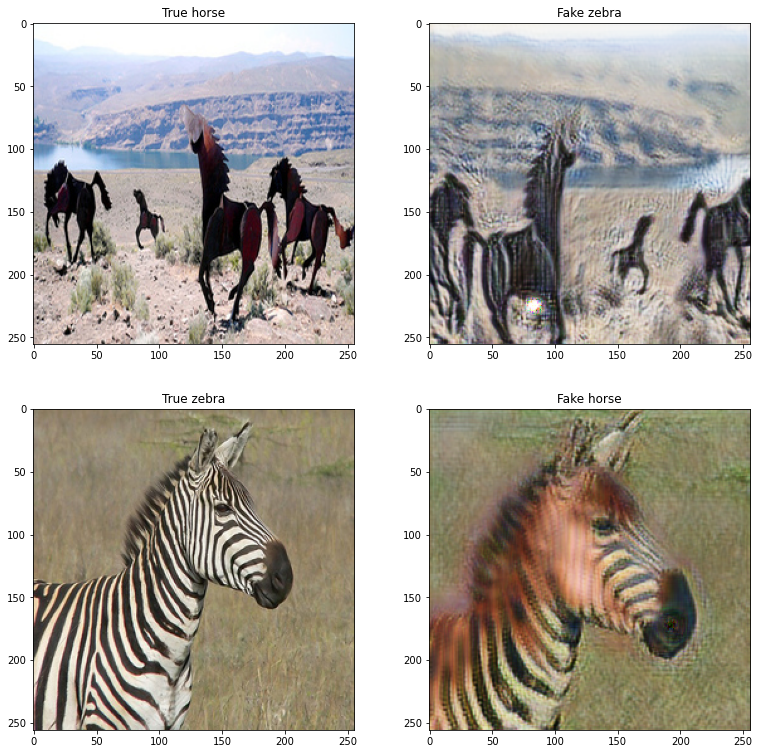

Epoch 15/20


  0%|          | 0/667 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0000e-05.
Adjusting learning rate of group 0 to 2.0000e-05.
Adjusting learning rate of group 0 to 2.0000e-05.
Epoch G-loss: 2.5543, epoch D-loss: 0.1565, epoch GAN-loss: 0.5114
--------------------------------------------------
Epoch 16/20


  0%|          | 0/667 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0000e-06.
Adjusting learning rate of group 0 to 2.0000e-06.
Adjusting learning rate of group 0 to 2.0000e-06.
Epoch G-loss: 2.5437, epoch D-loss: 0.1529, epoch GAN-loss: 0.5253
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/cycle_GAN.pth


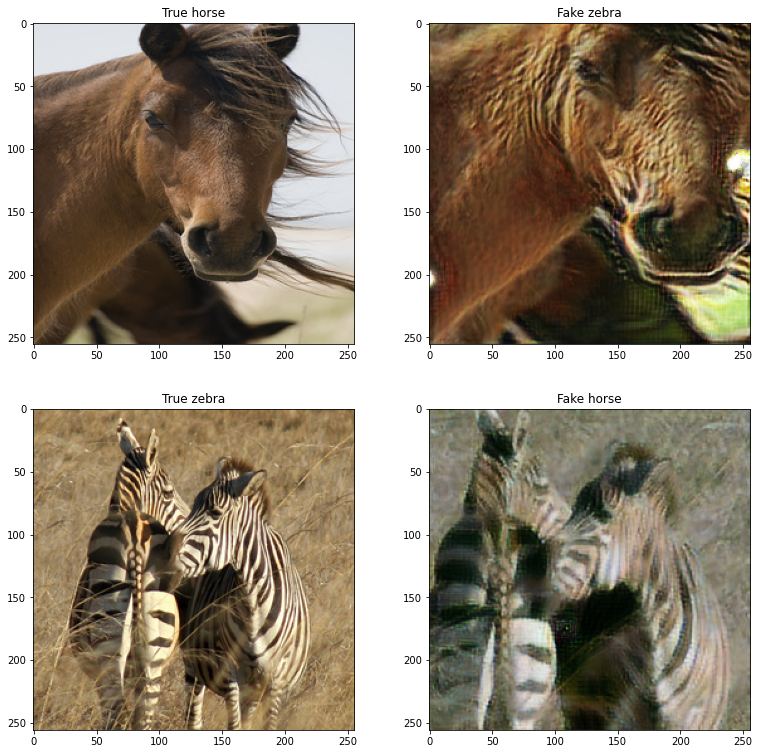

Epoch 17/20


  0%|          | 0/667 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [14]:
losses_GAN, losses_D, losses_G = [], [], []

try:
    ep, G_AB, G_BA, D_A, D_B, optimizer_G, optimizer_DA, optimizer_DB, scheduler_G, scheduler_DA, scheduler_DB = load_model(PATH)
    ep += 1
except Exception:
    ep = 0

for epoch in range(ep, epochs):

    print(f'Epoch {epoch + 1}/{epochs}')
    epoch_gan_loss, epoch_D_loss, epoch_G_loss = [], [], []
    for _, batch in enumerate(tqdm(train_dataloader, leave=False)):
        real_A, real_B = batch
        loss_G, loss_identity, loss_GAN, loss_cycle, fake_A, fake_B = generator_train_step(G_AB, G_BA, 
                                                                                           optimizer_G,
                                                                                           real_A, real_B)
        loss_D_A = discriminator_train_step(D_A, real_A, fake_A, optimizer_DA)
        loss_D_B = discriminator_train_step(D_B, real_B, fake_B, optimizer_DB)
        loss_D = (loss_D_A + loss_D_B) / 2
        epoch_gan_loss.append(loss_GAN.item())
        epoch_D_loss.append(loss_D.item())
        epoch_G_loss.append(loss_G.item())
    loss_G_value = np.array(epoch_G_loss).mean()
    loss_D_value = np.array(epoch_D_loss).mean()
    loss_GAN_value = np.array(epoch_gan_loss).mean()
    losses_G.append(loss_G_value)
    losses_D.append(loss_D_value)
    losses_GAN.append(loss_GAN_value)
    scheduler_G.step()
    scheduler_DA.step()
    scheduler_DB.step()
    print(f'Epoch G-loss: {loss_G_value:.4f}, epoch D-loss: {loss_D_value:.4f}, epoch GAN-loss: {loss_GAN_value:.4f}')
    print('-'*50)
    if (epoch + 1) % 2 == 0:
        checkpoint = { 
                  'epoch': epoch,
                  'G_AB': G_AB,
                  'G_BA': G_BA,
                  'optimizer_G': optimizer_G,
                  'D_A': D_A,
                  'D_B': D_B,
                  'optimizer_DA': optimizer_DA,
                  'optimizer_DB': optimizer_DB,
                  'scheduler_G': scheduler_G,
                  'scheduler_DA': scheduler_DA,
                  'scheduler_DB': scheduler_DB,
                  }
        save_model(checkpoint)
        show_evaluation(G_AB, G_BA, horses_test, zebras_test)